In [27]:
#!pip install torch torchaudio scikit-learn numpy
#!pip install soundfile

# IMPORT

In [28]:
import os
from collections import Counter

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from src.preprocessing.dataset import (
    list_ravdess_files,
    filter_audio_speech,
    RavdessDataset,
    extract_label_idx,
    IDX2LABEL,
)
from src.models.crnn import CRNN
from src.utils import set_seed, evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



# DEFINIZIONE DATA BASE

In [29]:

set_seed(42)

DATA_ROOT = "./data"
EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) lista file
all_files = list_ravdess_files(DATA_ROOT)
all_files = filter_audio_speech(all_files)
if len(all_files) == 0:
    raise RuntimeError("Nessun file trovato. Controlla DATA_ROOT e filter_audio_speech().")

# 2) labels per stratify
labels = [extract_label_idx(fp) for fp in all_files]
print("Tot files:", len(all_files))
print("Distribuzione classi:", Counter(labels))


Device: cuda
Tot files: 1440
Distribuzione classi: Counter({1: 192, 2: 192, 3: 192, 4: 192, 5: 192, 6: 192, 7: 192, 0: 96})


# SPLIT DATASET

In [30]:
# serve per vedere se stai usando la CPU o se hai CUDA
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))

# IMPORTANTE
# se qui la prima riga ti ritorna True allora sotto quando scrivi i DataLoader metti i pinmemory = True

CUDA available: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [31]:
from src.preprocessing.dataset import parse_ravdess_filename

def split_by_speakers(filepaths, train_speakers, val_speakers, test_speakers):
    train, val, test = [], [], []
    for fp in filepaths:
        actor = parse_ravdess_filename(fp)["actor"]
        if actor in train_speakers:
            train.append(fp)
        elif actor in val_speakers:
            val.append(fp)
        elif actor in test_speakers:
            test.append(fp)
    return train, val, test

In [ ]:

# 3) split random stratificato (Phase 1: NON speaker-independent)
#train_files, temp_files, train_y, temp_y = train_test_split(
#   all_files, labels, test_size=0.30, random_state=42, stratify=labels
#)
#val_files, test_files, _, _ = train_test_split(
#    temp_files, temp_y, test_size=0.50, random_state=42, stratify=temp_y
#)

#print(f"Split -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

# Speaker-independent split (attori disgiunti)
train_spk = [f"{i:02d}" for i in range(1, 17)]   # 01..18
val_spk   = [f"{i:02d}" for i in range(17, 21)]  # 19..22
test_spk  = [f"{i:02d}" for i in range(21, 25)]  # 23..24

train_files, val_files, test_files = split_by_speakers(all_files, train_spk, val_spk, test_spk)

print(f"Split SI -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

from collections import Counter
import torch

train_labels = [extract_label_idx(fp) for fp in train_files]
counts = Counter(train_labels)

weights = torch.tensor([1.0 / counts[i] for i in range(8)], dtype=torch.float, device=device)
weights = weights / weights.sum() * 8  # normalizzazione

print("Class counts:", counts)
print("Weights:", weights.detach().cpu().numpy())

# 4) dataset + loader
AUG_ON = True  # <-- switch globale (metti False per disattivare tutto)

aug_cfg = {
    "gain": True,
    "gain_db": (-3, 3),

    "time_shift": True,
    "time_shift_s": 0.03,   

    "noise": True,
    "snr_db": (25, 40),     

    "reverb": False,
    "reverb_ir_s": 0.04,
    "reverb_decay": 0.25,
}


train_ds = RavdessDataset(train_files, augmentation=AUG_ON, aug_config=aug_cfg)
val_ds   = RavdessDataset(val_files,   augmentation=False)   # NO augmentation su val
test_ds  = RavdessDataset(test_files,  augmentation=False)   # NO augmentation su test

# num_workers=0: più stabile su Windows/CPU (evita crash dei processi worker)
# pin_memory=False: utile solo con GPU (CUDA), su CPU non porta vantaggi
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# 5) model
model = CRNN(n_classes=8, n_mels=64).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=6)

best_val_acc = 0.0
best_path = "best_phase1.pt"

# HISTORY PER GRAFICO 
val_acc_hist = []
test_acc_hist = []


Split SI -> train 960 | val 240 | test 240
Class counts: Counter({1: 128, 2: 128, 3: 128, 4: 128, 5: 128, 6: 128, 7: 128, 0: 64})
Weights: [1.7777778 0.8888889 0.8888889 0.8888889 0.8888889 0.8888889 0.8888889
 0.8888889]


In [33]:

# 6) training loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = torch.nn.functional.cross_entropy(logits, y, weight=weights, label_smoothing=0.1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    val_loss, val_acc = evaluate(model, val_loader, device)
    test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, device)  # <-- test ogni epoca

    scheduler.step(val_acc)

    # salva history
    val_acc_hist.append(val_acc)
    test_acc_hist.append(test_acc_epoch)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"test acc {test_acc_epoch:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

Epoch 1/50 | train loss 2.0951 acc 0.1354 | val loss 2.0695 acc 0.1333 | test acc 0.1333
Epoch 2/50 | train loss 2.0441 acc 0.1844 | val loss 2.0270 acc 0.2042 | test acc 0.1458
Epoch 3/50 | train loss 1.9677 acc 0.2594 | val loss 1.9565 acc 0.2000 | test acc 0.2042
Epoch 4/50 | train loss 1.8710 acc 0.3042 | val loss 2.1154 acc 0.1708 | test acc 0.1667
Epoch 5/50 | train loss 1.8124 acc 0.3323 | val loss 2.1343 acc 0.1583 | test acc 0.1833
Epoch 6/50 | train loss 1.7710 acc 0.3667 | val loss 2.0579 acc 0.1708 | test acc 0.1958
Epoch 7/50 | train loss 1.7399 acc 0.3708 | val loss 2.1191 acc 0.1667 | test acc 0.1625
Epoch 8/50 | train loss 1.7128 acc 0.3823 | val loss 2.0293 acc 0.1917 | test acc 0.2125
Epoch 9/50 | train loss 1.6673 acc 0.4177 | val loss 2.0458 acc 0.1917 | test acc 0.2000
Epoch 10/50 | train loss 1.6475 acc 0.4229 | val loss 2.0854 acc 0.1667 | test acc 0.1750
Epoch 11/50 | train loss 1.6297 acc 0.4490 | val loss 2.1279 acc 0.1583 | test acc 0.1958
Epoch 12/50 | train

KeyboardInterrupt: 

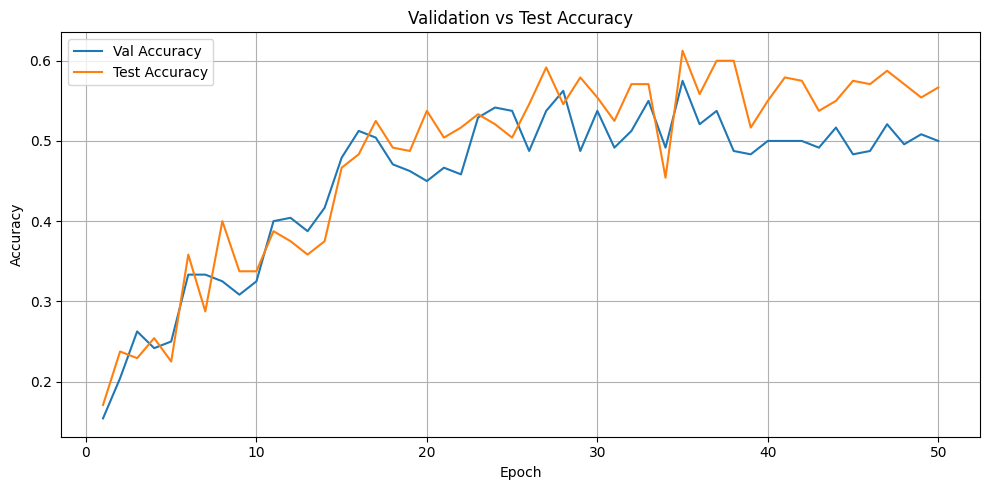


Best val acc: 0.575


C:\Users\franc\AppData\Local\Temp\ipykernel_28772\2561211432.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=de

TEST (best checkpoint) | loss 1.1940 acc 0.6125

Classification report:
              precision    recall  f1-score   support

     neutral     0.5714    0.5000    0.5333        16
        calm     0.7000    0.6562    0.6774        32
       happy     0.3333    0.1875    0.2400        32
         sad     0.6061    0.6250    0.6154        32
       angry     0.6667    0.7500    0.7059        32
     fearful     0.6786    0.5938    0.6333        32
     disgust     0.6000    0.5625    0.5806        32
   surprised     0.6078    0.9688    0.7470        32

    accuracy                         0.6125       240
   macro avg     0.5955    0.6055    0.5916       240
weighted avg     0.5971    0.6125    0.5955       240

Confusion matrix:
[[ 8  0  4  4  0  0  0  0]
 [ 3 21  0  7  0  1  0  0]
 [ 3  3  6  1  2  6  2  9]
 [ 0  4  2 20  0  0  6  0]
 [ 0  0  0  1 24  0  0  7]
 [ 0  2  2  0  1 19  4  4]
 [ 0  0  4  0  9  1 18  0]
 [ 0  0  0  0  0  1  0 31]]


In [ ]:

# Grafico accuracy train vs val
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_acc_hist, label="Val Accuracy")
plt.plot(epochs_range, test_acc_hist, label="Test Accuracy")
plt.title("Validation vs Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7) test finale con best checkpoint
print("\nBest val acc:", best_val_acc)
model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, device)
print(f"TEST (best checkpoint) | loss {test_loss:.4f} acc {test_acc:.4f}")

# 8) report dettagliato
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).cpu()
        preds = logits.argmax(dim=1).numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())

print("\nClassification report:")
target_names = [IDX2LABEL[i] for i in range(8)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))
